In [1]:
import DPrivacy as dp
from ChoiceMaker import DTChoice
from sklearn import model_selection, feature_selection
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz
%matplotlib inline
import pickle

In [157]:
class DB:
    def __init__(self, X, y, X_test, y_test, epsilon=1, depth=0, max_depth=0):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = X
        self.y = y
        self.X_test = X_test
        self.y_test = y_test
        self.depth = depth
        self.max_depth = max_depth
        #branching_factor?
        
class DBMetas:
    def __init__(self):
        self.sensitivities = {'nrow': 1, 'ncol': 0, 'eps': 0, 'depth': 0}
    
    def __call__(self, dataset):
        return {'nrow': dataset.X.shape[0], 
                'ncol': dataset.X.shape[1],
                'eps': dataset.epsilon, 
                'depth': dataset.depth}
def entropy(y):
    arr = pd.value_counts(y)
    arr = arr[arr > 0]
    arr = arr/arr.sum()
    return (-np.log2(arr) * arr).sum()

In [3]:
#alg_list
class TreePart:
    def __init__(self, splits=5):
        self.splits=splits
        self.kf = model_selection.KFold(splits)
        self.lo = model_selection.LeaveOneOut()
    def get_expected_correct(self, y, epsilon):
        tot_correct = 0
        if len(y) < self.splits:
            gen = self.lo.split(y)
        else:
            gen = self.kf.split(y)
        for train_idx, test_idx in gen:
            hist = pd.value_counts(y.iloc[train_idx])
            noisy_hist = dp.hist_noiser(hist, epsilon)
            pred = noisy_hist.idxmax()
            tot_correct += (y.iloc[test_idx] == pred).sum()
        return tot_correct / len(y)
    
class Leaf(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        return 1.0-self.get_expected_correct(db.y, db.epsilon)
    def run(self, db):
        frequencies = pd.value_counts(db.y)
        noisy_freqs = dp.hist_noiser(frequencies, db.epsilon)
        return np.repeat(noisy_freqs.idxmax(), db.y_test.size)
    
#This error is a little optimistic because it doesn't account for the exponential mechanism at low epsilon.
class Split(TreePart):
    def error(self, db):
        if len(db.y) == 0:
            return 0
        corrects = []
        probs = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            correct = 0
            tot_ent = 0
            for cat in cats:
                leaf_correct = self.get_expected_correct(db.y[x == cat], db.epsilon)
                correct += leaf_correct * (x == cat).sum()
                ent = entropy(db.y[x == cat])
                tot_ent += ent*(x==cat).sum()
            correct /= len(db.y)
            corrects.append(correct)
            probs.append(tot_ent)
        C = np.array(corrects)
        D = np.exp(C*db.epsilon)
        probs = D/D.sum()
        return 1-probs.dot(C)
    def run(self, db):
        return None
tree_algs = {'leaf': Leaf(), 'split': Split()}

In [154]:
C = np.array([0.5, 0.75, 0.8, 0.3])
D = np.exp(C*0.1)
probs = D / D.sum()
probs.dot(C)

array([ 0.5 ,  0.75,  0.8 ,  0.3 ])

In [156]:
np.exp(C)

array([ 1.64872127,  2.11700002,  2.22554093,  1.34985881])

In [4]:
class PDTree:
    def __init__(self):
        pass
    
    def entropy(self, y):
        arr = pd.value_counts(y)
        arr = arr[arr > 0]
        arr = arr/arr.sum()
        return (-np.log2(arr) * arr).sum()
    
    def decision_helper(self, db, cm):
        action = cm.choose(db)
        if db.depth == db.max_depth:
            action = leaf.run(db)
        if action is not None:
            return action
        utils = []
        for col in db.X.columns:
            x = db.X[col]
            cats = x.cat.categories
            cur_ent = 0
            for cat in cats:
                ent = self.entropy(db.y[x == cat])
                cur_ent += ent * (x == cat).sum()
            #cur_ent /= len(db.y)
            utils.append(-cur_ent)
        best_idx = dp.exp_mech(utils, db.epsilon, 1) #Change sensitivity
        col_name = db.X.columns[best_idx]
        new_cols = db.X.columns[db.X.columns != col_name]
        splitX = db.X[col_name]
        splitX_test = db.X_test[col_name]
        preds = np.repeat(db.y.cat.categories[0], len(db.y_test))
        for att in splitX_test.unique():
            train_split = db.X.loc[splitX == att, new_cols]
            y_split = db.y[splitX == att]
            test_split_loc = db.X_test[col_name] == att 
            test_split = db.X_test.loc[test_split_loc, new_cols]
            test_split_y = db.y_test.loc[test_split_loc]
            if(test_split_y.size > 0):
                db_new = DB(train_split, y_split, test_split, test_split_y, db.epsilon, db.depth+1, db.max_depth)
                preds[test_split_loc] = self.decision_helper(db_new, cm)
        return preds
    
    def fit_and_predict(self, data, cm):
        budget = data.epsilon / data.X.shape[1]
        data.epsilon = budget
        return self.decision_helper(data, cm)

### DATASETS

In [5]:
nurs = pd.read_csv('../datasets/nursery.data', header=None)
nurs = nurs.apply(lambda x: x.astype('category'))

In [6]:
skin = pd.read_csv('data/Skin.csv', sep='\t', header=None)
skin = skin.apply(lambda x: x.astype('category'))

In [7]:
default = pd.read_csv('data/default.csv', header=1)
default = default.drop('ID', axis=1)

In [8]:
def discretize(col, n_quantiles):
    L = np.linspace(0, 1, n_quantiles, endpoint=False) + 1.0/n_quantiles
    L = col.quantile(L)
    return L.searchsorted(col)

In [9]:
cols = [c for c in default.columns if 'AMT' in c]
default[cols] = default[cols].apply(lambda x: discretize(x, 5))
#Columns remaining: AGE, LIMIT_BAL, PAY_n,
default.LIMIT_BAL = discretize(default.LIMIT_BAL, 10)
default.AGE = discretize(default.AGE, 6)
default = default.apply(lambda x: x.astype('category'))

In [10]:
loan = pd.read_csv('../datasets/student-loan.csv')
loan = loan.apply(lambda x: x.astype('category'))

In [11]:
adult = pd.read_csv('data/adult.data', header=None)
adult = adult.rename(columns = {0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 
                                4: 'education_num', 5: 'marital_status', 6: 'occupation',
                                7: 'relationship', 8: 'race', 9: 'sex', 10: 'capital_gain',
                                11: 'capital_loss', 12: 'hours_per_week', 13: 'native_country', 14: 'TARGET'})

In [12]:
adult.age = discretize(adult.age, 7)
adult.fnlwgt = discretize(adult.fnlwgt, 10)
adult.capital_gain = discretize(adult.capital_gain, 6)
adult.capital_loss = discretize(adult.capital_loss, 6)
adult.hours_per_week = discretize(adult.hours_per_week, 6)

In [13]:
def world_region(elem):
    elem = elem.strip()
    if elem in ['Cuba', 'Jamaica', 'Mexico', 'South', 'Puerto-Rico', 'Honduras', 'Columbia', 'Ecuador', 'Haiti',\
                'Dominican-Republic', 'El-Salvador', 'Guatemala', 'Peru', 'Trinadad&Tobago', 'Nicaragua']:
        return 1
    if elem in ['Philippines', 'Cambodia', 'Thailand', 'Laos', 'Taiwan', 'China', 'Japan',\
                'Outlying-US(Guam-USVI-etc)', 'Hong', 'Vietnam', 'India', 'Iran']:
        return 2
    if elem in ['England', 'Canada', 'France', 'Germany', 'Italy', 'Poland', 'Portugal',\
                'Yugoslavia', 'Scotland', 'Greece', 'Ireland', 'Hungary', 'Holand-Netherlands']:
        return 3
    if elem == 'United-States':
        return 4
    if elem == '?':
        return 5
    assert False
adult.native_country = adult.native_country.apply(world_region)

In [14]:
adult = adult.apply(lambda x: x.astype('category'))

In [15]:
lending = pd.read_csv('data/fam_credit_ss.csv')

In [16]:
lending.income = discretize(lending.income, 8)
lending.age = discretize(lending.age, 5)
lending.work_hours = discretize(lending.work_hours, 5)
lending.employment = discretize(lending.employment, 6)
lending.auto_insurance = discretize(lending.auto_insurance, 10)

In [17]:
lending = lending.apply(lambda x: x.astype('category'))

In [18]:
leaf = Leaf()
split = Split()

In [19]:
class null_cm:
    def __init__(self):
        pass
    def choose(self, db):
        if db.depth < db.max_depth:
            return split.run(db)
        else:
            return leaf.run(db)

### Experiments

In [21]:
def get_train_dbs(seed_db, eps, prng):
    regs = []
    X = []
    D = []
    for l in range(1, 4): #Used to be 6
        for x in range(2**(l+3)):
            cols = prng.permutation(seed_db.columns[:-1])
            db_groups = seed_db.groupby(list(cols[:l])).groups
            idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
            L = idxs.size
            L = min(L, 5000)
            L = prng.randint(0.7*L, L)
            idxs = prng.choice(idxs, L)
            data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
            regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
            X.append(DBMetas()(data))
            D.append(data)
    #Large DBs    
    for x in range(16):
        cols = seed_db.columns[:-1]
        L = len(seed_db)
        L = min(L, 5000)
        L = prng.randint(0.7*L, L)
        new_db = seed_db.sample(L, random_state=prng)
        data = DB(new_db.loc[:, cols], new_db.loc[:, seed_db.columns[-1]], None, None, epsilon=eps, depth=0)
        regs.append({name: alg.error(data) for name, alg in tree_algs.items()})
        X.append(DBMetas()(data))
        D.append(data)
    return (regs, X, D)

In [22]:
def get_test_dbs(seed_db, eps, prng):
    cols = seed_db.columns[:-1]
    y_col = seed_db.columns[-1]
    L = len(seed_db)
    L = min(L, int(5000/0.7))
    L = prng.randint(0.7*L, L)
    new_db = seed_db.sample(L, random_state=prng).reset_index(drop=True)
    split = int(0.7*L)
    md = min(len(cols), 4)
    d = DB(new_db.loc[:split, cols], new_db.loc[:split, y_col], \
           new_db.loc[split:, cols], new_db.loc[split:, y_col], epsilon=eps, max_depth=md)
    return d

In [23]:
prng=np.random.RandomState(12345)
def get_test(db, prng):
    dbs = []
    eps_vals = np.arange(0.1, 1.0, 0.3)*10
    for i in range(0, 3):
        for e in eps_vals:
            dbs.append(get_test_dbs(db, e, prng))
    return dbs
dbs = [get_test(db, prng) for db in [nurs, default, loan, adult, lending]]

In [24]:
def get_cm(db):
    eps_vals = np.arange(0.1, 1.0, 0.1)
    info = [get_train_dbs(db, x, prng) for x in eps_vals]
    regrets, X, datas = zip(*info)
    regrets = pd.concat([pd.DataFrame(r) for r in regrets])
    X = pd.concat([pd.DataFrame(r) for r in X])
    return (DTChoice(X, DBMetas(), tree_algs, reps=1, y=regrets), datas)

from multiprocessing import Pool
p = Pool(6)
out = p.map(get_cm, [nurs, default, loan, adult, lending])

In [41]:
cms, dt = list(zip(*out))
data_train = [x for y in dt for z in y for x in z]

In [30]:
import pickle
pickle.dump(out, open('DTree/dtree_output.pkl', 'wb'))
#cms = pickle.load(open('DTree/cm_list.pkl', 'rb'))

In [127]:
for cm in cms:
    cm.regrets = cm.regrets[['split', 'leaf']]
    cm.y = cm.regrets.idxmin(axis=1)
    cm.retrain_model(C=0.05)

In [129]:
def combine_cms(cms, C=0, msl=1):
    Xs = pd.concat([cm.X for cm in cms], ignore_index=True)
    regs = pd.concat([cm.regrets for cm in cms], ignore_index=True)
    dt = DTChoice(Xs, DBMetas(), tree_algs, reps=1, y=regs, C=0)
    dt.model = DecisionTreeClassifier(min_samples_leaf=msl)
    dt.model = dt.model.fit(dt.X, dt.y, dt.regrets, dt.C)
    return dt

In [130]:
def get_results(test_idx):
    dt = PDTree()
    big_cm = combine_cms(cms[:test_idx] + cms[(test_idx+1):], msl=10)
    dbs_list = dbs[test_idx]
    budgets = [x.epsilon for x in dbs_list]
    L = []
    for t in dbs_list:
        print('Start')
        L.append( dt.fit_and_predict(t, null_cm()) )
    #Reset budgets
    for i in range(len(dbs_list)):
        dbs_list[i].epsilon = budgets[i]
    L2 = []
    for t in dbs_list:
        print('Start')
        L2.append(dt.fit_and_predict(t, big_cm))
    for i in range(len(dbs_list)):
        dbs_list[i].epsilon = budgets[i]
    M = np.array([(L[i] == dbs[test_idx][i].y_test).sum() / len(dbs[test_idx][i].y_test) for i in range(len(dbs[test_idx]))])
    M2 = np.array([(L2[i] == dbs[test_idx][i].y_test).sum() / len(dbs[test_idx][i].y_test) for i in range(len(dbs[test_idx]))])
    return (L, M, L2, M2)

In [131]:
(run_null0, perf_null0, run0, perf0) = get_results(0)

Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start


In [132]:
perf_null0.mean()

0.60066958546050564

In [133]:
perf0.mean()

0.60030287578474661

In [27]:
pd.DataFrame(DBMetas()(dbs[0][0]), index=[0])

,depth,eps,ncol,nrow
0,0,1.0,8,3837


In [46]:
big_cm = combine_cms(cms[:0] + cms[(0+1):], msl=10)

In [30]:
test_idx = 0
big_cm = combine_cms(cms[:test_idx] + cms[(test_idx+1):])
big_cm.model = DecisionTreeClassifier(min_samples_leaf=10)
big_cm.model = big_cm.model.fit(big_cm.X, big_cm.y, big_cm.regrets, big_cm.C)

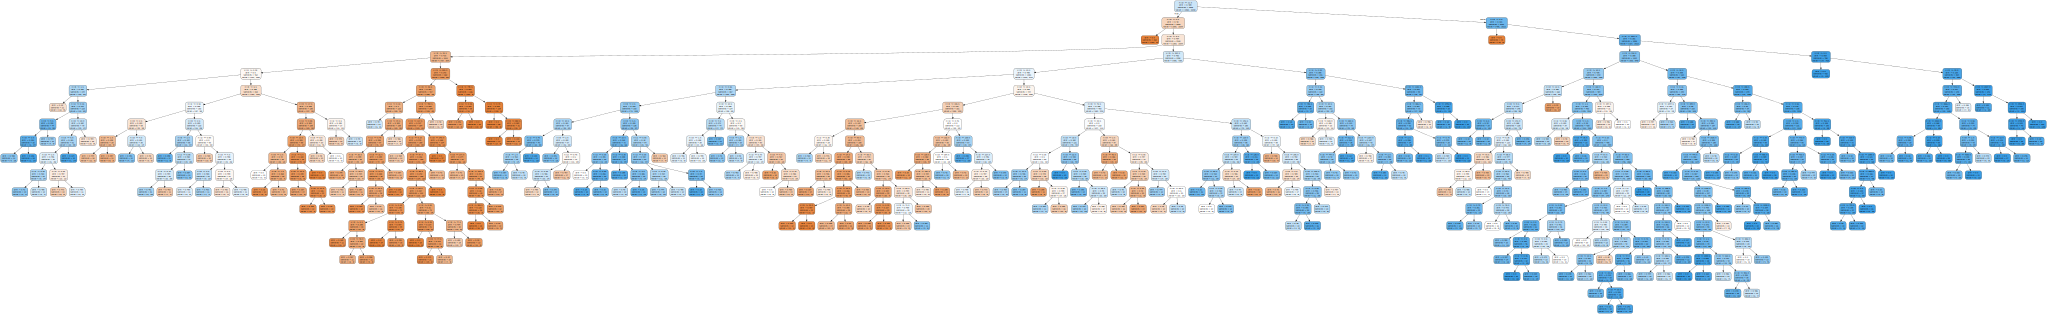

In [31]:
dot_data = export_graphviz(big_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [47]:
X = big_cm.X
y = big_cm.y
r = big_cm.regrets
pd.value_counts(y)

split    2655
leaf     1953
dtype: int64

In [72]:
X[np.all((X.ncol <= 8.5, X.nrow >= 562.5, X.eps <= 0.85, X.depth <= 1.5), axis=0)]

,depth,eps,ncol,nrow
1154,1,0.1,7,597
1159,1,0.1,7,794
1164,1,0.1,7,698
1165,1,0.1,7,891
1166,1,0.1,7,687
1264,0,0.1,8,942
1265,0,0.1,8,835
1266,0,0.1,8,748
1267,0,0.1,8,836
1268,0,0.1,8,837


In [101]:
{name: alg.error(m[0]) for name, alg in tree_algs.items()}

{'leaf': 0.099088838268792667, 'split': 0.099088838268792667}

In [103]:
m[0].X

,absense,bankrupcy,disabled,enlist,enrolled,enrolled_credit,male,no_payment_due
492,5,0,0,marines,occ,3,1,pos
289,7,0,0,0,ucla,9,1,neg
404,0,0,0,0,occ,11,1,pos
207,6,0,1,foreign_legion,smc,14,1,pos
738,0,0,0,0,ucla,10,0,pos
634,3,0,0,0,smc,15,1,pos
49,0,0,1,0,ucla,11,1,pos
744,2,0,0,0,ucla,10,1,pos
724,2,0,0,0,occ,4,1,neg
677,0,0,0,foreign_legion,uci,6,1,pos


In [87]:
pd.value_counts(DDX.y)

0    502
1     95
Name: unemployed, dtype: int64

In [100]:
m = []
cnt = 0
for d in data_train:
    if DBMetas()(d)['nrow'] == 878:
        m.append(d)
        break
    cnt += 1
m

In [79]:
cnt

2306

In [55]:
DBMetas()(DDX)

{'depth': 1, 'eps': 0.10000000000000001, 'ncol': 22, 'nrow': 39}

In [70]:
X[np.all((X.depth==1, X.eps==0.1, X.ncol==22, X.nrow==39), axis=0)]

,depth,eps,ncol,nrow
2,1,0.1,22,39


In [388]:
seed_db = default
l=1

cols = prng.permutation(seed_db.columns[:-1])
db_groups = seed_db.groupby(list(cols[:l])).groups
idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
L = idxs.size
L = min(L, 5000)
L = prng.randint(0.7*L, L)
idxs = prng.choice(idxs, L)
data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
regs = {name: alg.error(data) for name, alg in tree_algs.items()}

In [389]:
regs

{'leaf': 0.38461538461538458, 'split': 0.17948717948717952}

In [331]:
seed_db = nurs
eps=0.5
regs = []
X = []
l = 5
cols = prng.permutation(seed_db.columns[:-1])
db_groups = seed_db.groupby(list(cols[:l])).groups
idxs = db_groups[list(db_groups)[prng.randint(len(db_groups))]]
L = idxs.size
L = min(L, 5000)
L = prng.randint(0.7*L, L)
idxs = prng.choice(idxs, L)
data = DB(seed_db.loc[idxs, cols[l:]], seed_db.loc[idxs, seed_db.columns[-1]], None, None, epsilon=eps, depth=l)
regs = {name: alg.error(data) for name, alg in tree_algs.items()}
regs

{'leaf': 0.76190476190476186, 'split': 0.1428571428571429}

In [134]:
(run_null1, perf_null1, run1, perf1) = get_results(1)

Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start


In [135]:
perf_null1.mean()

0.72241402639316465

In [136]:
perf1.mean()

0.72023480733776424

In [ ]:
(run_null2, perf_null2, run2, perf2) = get_results(2)

In [71]:
perf_null2.mean()

0.71087550644255593

In [72]:
perf2.mean()

0.7102600589173147

In [137]:
(run_null3, perf_null3, run3, perf3) = get_results(3)

Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start


In [138]:
perf_null3.mean()

0.70824971763908062

In [139]:
perf3.mean()

0.71581215286568445

In [140]:
test_idx=3
big_cm = combine_cms(cms[:test_idx] + cms[(test_idx+1):], msl=10)

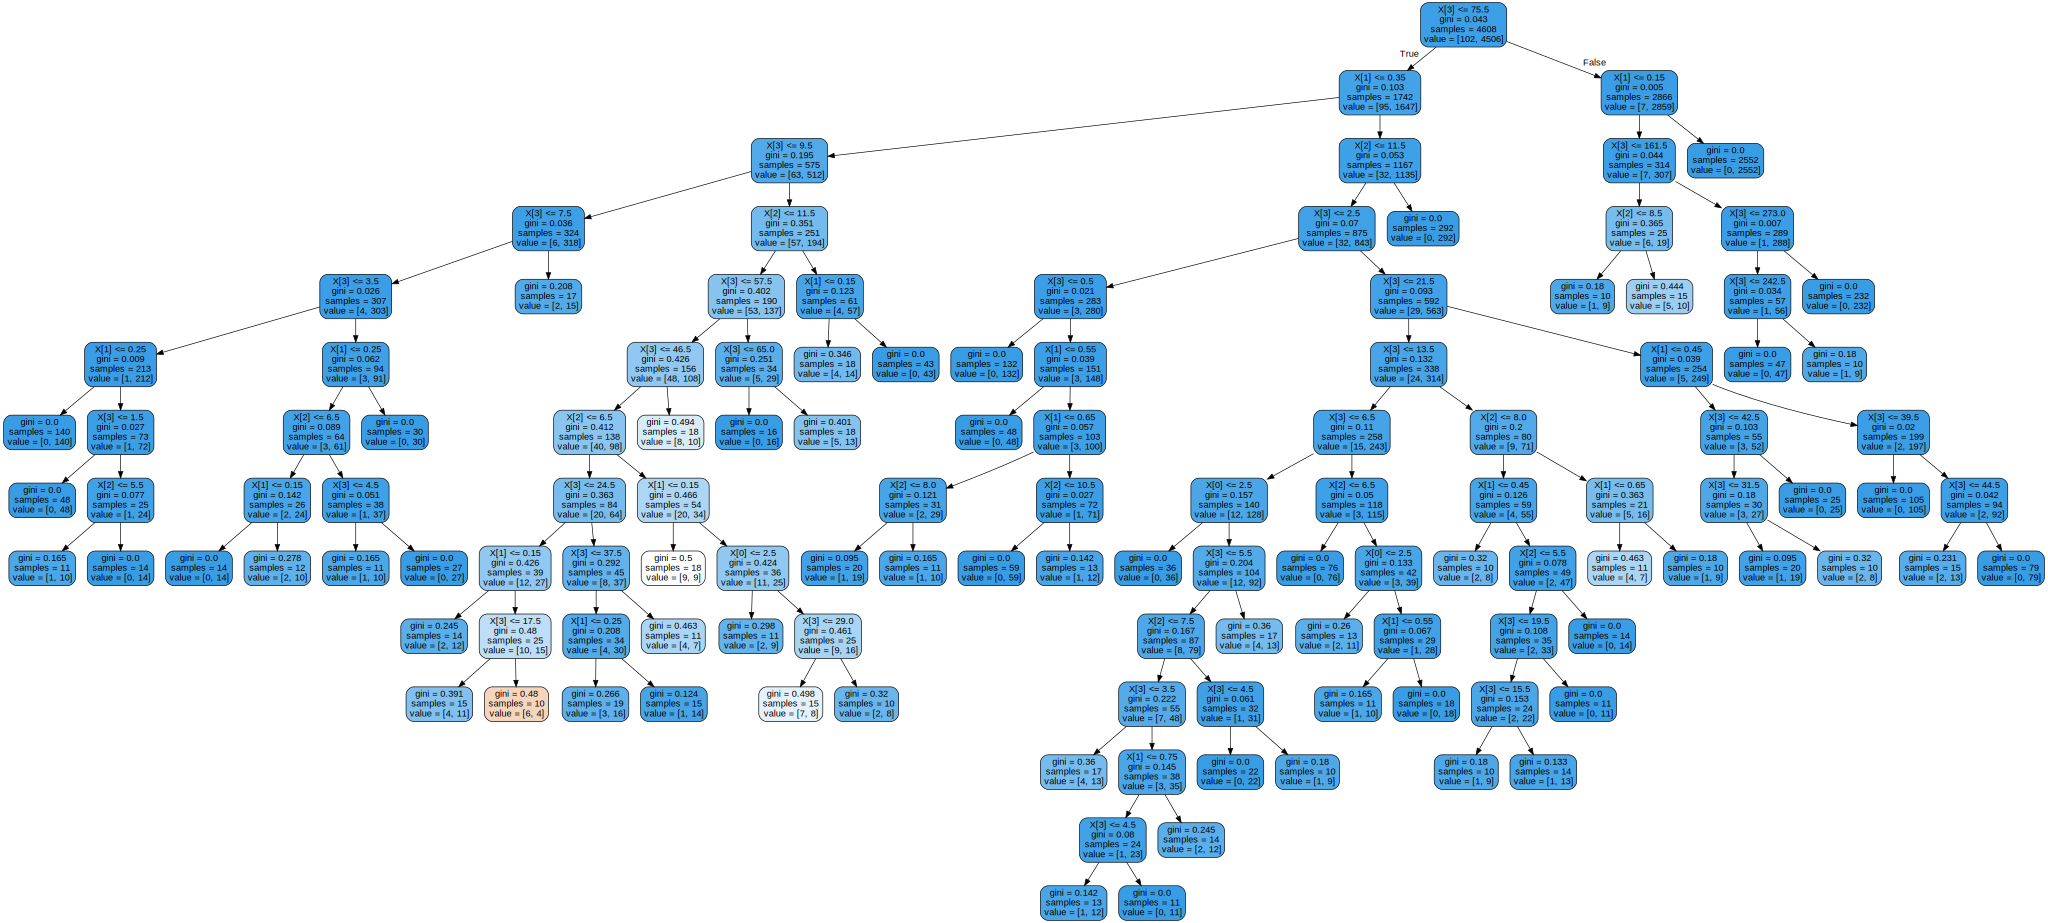

In [145]:
dot_data = export_graphviz(big_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [144]:
pd.value_counts(big_cm.y)

split    4506
leaf      102
dtype: int64

In [76]:
(run_null4, perf_null4, run4, perf4) = get_results(4)

Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start


In [77]:
perf_null4.mean()

0.71873737276618288

In [78]:
perf4.mean()

0.70963393883854575

In [79]:
(run_null5, perf_null5, run5, perf5) = get_results(5)

Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start
Start


In [82]:
perf_null5.mean()

0.73163036884815236

In [83]:
perf5.mean()

0.71929006526787087

In [90]:
dbs[4][0].epsilon

0.071428571428571425

In [91]:
cms[4]